# Projet Machine learning  

# Objectif :
- Comprendre du mieux possible nos données 
- prédire les prix des voitures d'occasion avec des caractéristiques données en nous référant sur notre target variable **price**



Importer les librairies utilisées

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from utilities import supprimer_unit

Importer le fichier csv qui contient le dataset des voitures et les features relatives pour chaque voiture

In [2]:
cars = pd.read_csv('data/Car details v3.csv')
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


Les dimensions et la description de notre dataset :

In [3]:
print(" les dimensions de notre dataset :", cars.shape)
print(" la taille de notre dataset :", cars.size)

 les dimensions de notre dataset : (8128, 13)
 la taille de notre dataset : 105664


In [4]:
cars.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


**Les données manquantes :** On voit qu'il faut nettoyer les lignes où des nulls sont présents :

In [5]:
cars.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

**Visualisation des catégories des attributs catégoriels dont certains que l'on transformera :**

In [6]:
for col in cars.select_dtypes('object'):
    print(f'{col :-<50} {cars[col].unique()}')
    print('\n')

name---------------------------------------------- ['Maruti Swift Dzire VDI' 'Skoda Rapid 1.5 TDI Ambition'
 'Honda City 2017-2020 EXi' ... 'Tata Nexon 1.5 Revotorq XT'
 'Ford Freestyle Titanium Plus Diesel BSIV'
 'Toyota Innova 2.5 GX (Diesel) 8 Seater BS IV']


fuel---------------------------------------------- ['Diesel' 'Petrol' 'LPG' 'CNG']


seller_type--------------------------------------- ['Individual' 'Dealer' 'Trustmark Dealer']


transmission-------------------------------------- ['Manual' 'Automatic']


owner--------------------------------------------- ['First Owner' 'Second Owner' 'Third Owner' 'Fourth & Above Owner'
 'Test Drive Car']


mileage------------------------------------------- ['23.4 kmpl' '21.14 kmpl' '17.7 kmpl' '23.0 kmpl' '16.1 kmpl' '20.14 kmpl'
 '17.3 km/kg' '23.59 kmpl' '20.0 kmpl' '19.01 kmpl' '17.3 kmpl'
 '19.3 kmpl' nan '18.9 kmpl' '18.15 kmpl' '24.52 kmpl' '19.7 kmpl'
 '22.54 kmpl' '21.0 kmpl' '25.5 kmpl' '26.59 kmpl' '21.5 kmpl' '20.3 kmpl'
 '21.4 k

<AxesSubplot:ylabel='fuel'>

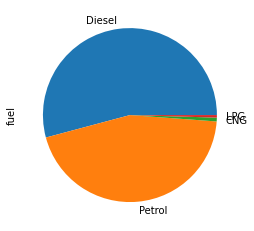

In [7]:
cars["fuel"].value_counts(normalize=True).plot(kind='pie')

<AxesSubplot:ylabel='seller_type'>

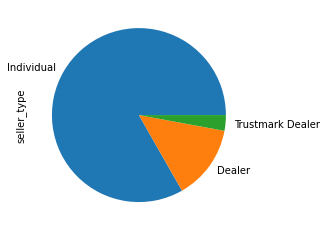

In [8]:
cars["seller_type"].value_counts(normalize=True).plot(kind='pie')

<AxesSubplot:ylabel='transmission'>

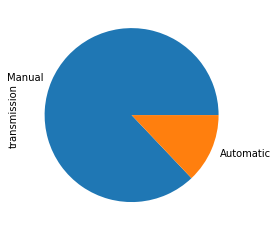

In [9]:
cars["transmission"].value_counts(normalize=True).plot(kind='pie')

<AxesSubplot:ylabel='owner'>

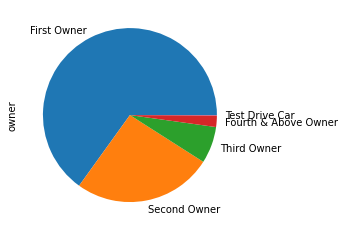

In [10]:
cars["owner"].value_counts(normalize=True).plot(kind='pie')

On visualise la proportion en chiffres cette fois des valeurs dans les attributs catégoriels (outre les valeurs numériques)

In [11]:
for col in ['seller_type','transmission','fuel', 'owner']:
    print(cars[col].value_counts()/cars.shape[0],'\n')

Individual          0.832431
Dealer              0.138533
Trustmark Dealer    0.029035
Name: seller_type, dtype: float64 

Manual       0.870817
Automatic    0.129183
Name: transmission, dtype: float64 

Diesel    0.541585
Petrol    0.446727
CNG       0.007013
LPG       0.004675
Name: fuel, dtype: float64 

First Owner             0.650714
Second Owner            0.258981
Third Owner             0.068282
Fourth & Above Owner    0.021407
Test Drive Car          0.000615
Name: owner, dtype: float64 



## Preprocessing

On convertit les roupies du dataset en euros

In [12]:
def rupees_to_euros(elem):
    return elem*0.01211

cars['selling_price'] = cars['selling_price'].apply(rupees_to_euros)
cars

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,5449.50,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,4480.70,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,1913.38,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,2724.75,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,1574.30,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,Hyundai i20 Magna,2013,3875.20,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
8124,Hyundai Verna CRDi SX,2007,1634.85,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
8125,Maruti Swift Dzire ZDi,2009,4626.02,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
8126,Tata Indigo CR4,2013,3511.90,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


On supprime les null puis on reset les index pour qu'ils s'adaptent.

In [13]:
cars = cars.dropna()
cars = cars.reset_index(drop=True) 
cars

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,5449.50,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,4480.70,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,1913.38,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,2724.75,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,1574.30,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7901,Hyundai i20 Magna,2013,3875.20,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
7902,Hyundai Verna CRDi SX,2007,1634.85,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
7903,Maruti Swift Dzire ZDi,2009,4626.02,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
7904,Tata Indigo CR4,2013,3511.90,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


On remarque bien qu'il n'y a plus de valeur null.

In [14]:
cars.isnull().sum() 

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64

On supprime certains attributs : name a une faible corrélation avec le prix, torque est difficilement lisible et seats a également une faible corrélation avec le prix, nous pouvons donc nous en débarasser .

In [15]:
cars = cars.drop(['torque','name'],axis=1)
cars

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,2014,5449.50,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,5.0
1,2014,4480.70,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,5.0
2,2006,1913.38,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,5.0
3,2010,2724.75,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,5.0
4,2007,1574.30,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,5.0
...,...,...,...,...,...,...,...,...,...,...,...
7901,2013,3875.20,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,5.0
7902,2007,1634.85,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,5.0
7903,2009,4626.02,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,5.0
7904,2013,3511.90,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,5.0


Ici nous supprimons les valeurs LPG et CNG pour l'attribut de fuel, Trustmark Dealer pour l'attribut de seller_type, Third Owner, Fourth  & Above Owner et Test Drive pour l'attribut owner, cela nous permet par la suite de les encoder binairement.

In [16]:
cars = cars.drop(cars[cars.fuel == 'LPG'].index)
cars = cars.drop(cars[cars.fuel == 'CNG'].index)
cars = cars.drop(cars[cars.seller_type == 'Trustmark Dealer'].index)
cars = cars.drop(cars[cars.owner == 'Third Owner'].index)
cars = cars.drop(cars[cars.owner == 'Fourth & Above Owner'].index)
cars = cars.drop(cars[cars.owner == 'Test Drive Car'].index)

cars = cars.reset_index(drop=True) 

In [17]:
for col in ['seller_type','transmission','fuel', 'owner']:
    print(cars[col].value_counts()/cars.shape[0],'\n')

Individual    0.841405
Dealer        0.158595
Name: seller_type, dtype: float64 

Manual       0.868151
Automatic    0.131849
Name: transmission, dtype: float64 

Diesel    0.565563
Petrol    0.434437
Name: fuel, dtype: float64 

First Owner     0.717363
Second Owner    0.282637
Name: owner, dtype: float64 



Ici nous utilisons la fonction que nous avons définie dans le fichier utilities.py, supprimer_unit pour ne garder que la valeur numérique des attributs cités

In [18]:
supprimer_unit(cars,'max_power','bhp')

In [19]:
supprimer_unit(cars,'mileage', 'kmpl')

In [20]:
supprimer_unit(cars,'engine', 'CC')

Ensuite, on supprime les prix aberrants.

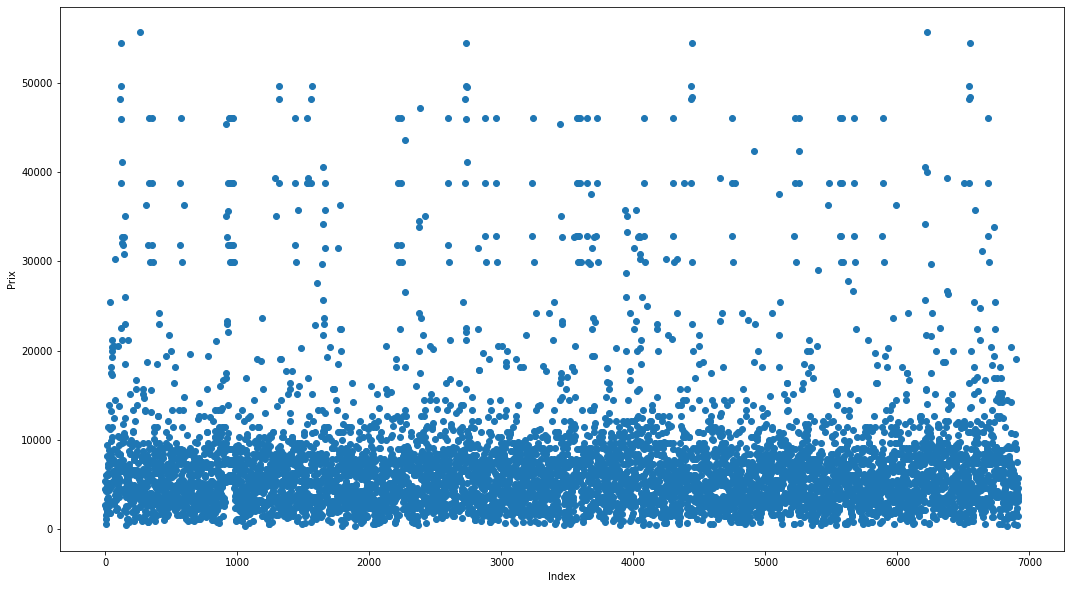

In [21]:
cars = cars[cars['selling_price']<60000] 

fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(cars.index,cars['selling_price'])
 
# x-axis label
ax.set_xlabel('Index')
 
# y-axis label
ax.set_ylabel('Prix')
plt.show()

On s'occupe ici du déséquilibre pour les attributs seller_type, transmission, fuel, owner, pour cela on trie tout d'abord par owner en commençant par la valeur 1, car le 0 est majoritaire, puis on trie en fonction de seller_type et transmission en affichant les 0 en premier classiquement, puisqu'on supprime par la suite les lignes avec les 1 qui sont majoritaires. On peut observer juste après que l'équilibre entre les différents attributs catégoriels s'est bien fait.

In [22]:
cars.sort_values(by=['owner'],ascending=False,inplace=True)
cars.sort_values(by=['seller_type','transmission'],inplace=True)
cars.drop(cars.index[2000:7582], axis=0,inplace=True)

for col in ['seller_type','transmission','fuel','owner']:
    print(cars[col].value_counts()/cars.shape[0],'\n')

Individual    0.505
Dealer        0.495
Name: seller_type, dtype: float64 

Manual       0.601
Automatic    0.399
Name: transmission, dtype: float64 

Diesel    0.598
Petrol    0.402
Name: fuel, dtype: float64 

First Owner     0.623
Second Owner    0.377
Name: owner, dtype: float64 



Ici nous nous occupons de la partie encodage, les 4 attributs cités sont transformés en one hot vectors, car ils ne peuvent pas être transformés binairement en ayant du sens étant donné que ce sont des chaines de caractères qui n'expriment pas une valeur supérieure objective. 

In [23]:
cols_onehot=['fuel','seller_type','transmission','owner']
cars = pd.get_dummies(cars,columns=cols_onehot)
cars

,year,selling_price,km_driven,mileage,engine,max_power,seats,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Second Owner
3455,2017,17559.50000,7000,14.53,1794,138.10,5.0,0,1,1,0,1,0,0,1
4562,2012,11201.75000,96000,19.62,1998,190.00,5.0,1,0,1,0,1,0,0,1
2375,2015,19981.50000,91000,12.55,2982,168.50,7.0,1,0,1,0,1,0,0,1
2831,2014,6660.50000,31000,17.21,1197,103.60,5.0,0,1,1,0,1,0,0,1
5318,2015,19981.50000,91000,12.55,2982,168.50,7.0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2930,2011,4238.50000,100000,23.00,1396,90.00,5.0,1,0,0,1,0,1,0,1
5539,2013,4601.80000,110000,21.27,1396,88.76,5.0,1,0,0,1,0,1,0,1
4723,2011,2785.28789,40000,20.00,1399,68.00,5.0,1,0,0,1,0,1,0,1
5541,2012,4844.00000,103655,22.32,1582,126.30,5.0,1,0,0,1,0,1,0,1


## Matrice de correlation  :

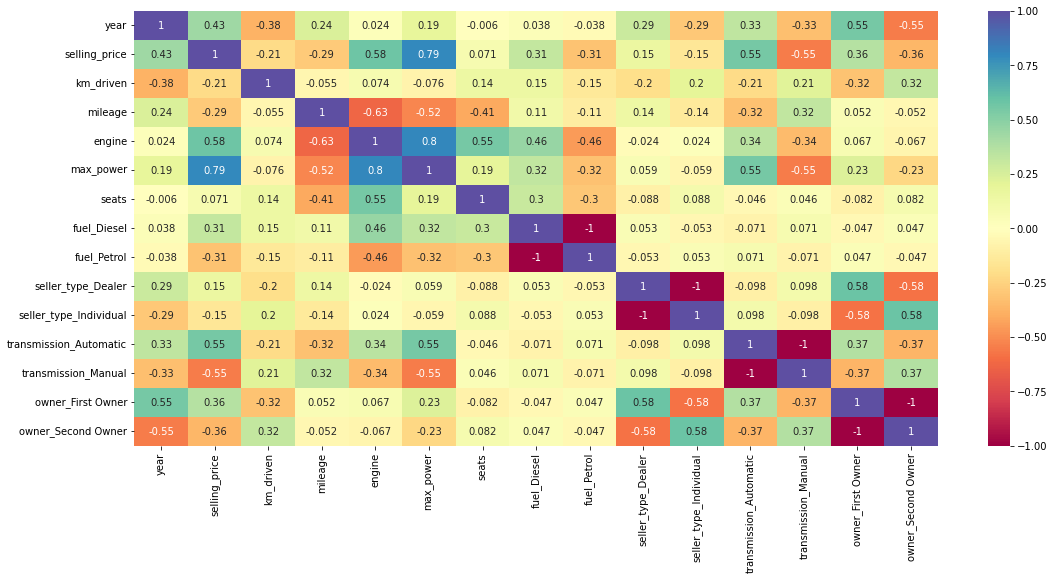

In [24]:
plt.figure(figsize=(18,8))
sns.heatmap(cars.corr(),annot=True,cmap= 'Spectral')
plt.show()

On supprime certains attributs :  seats qui a une faible corrélation avec le prix, nous pouvons donc nous en débarasser .

In [25]:
cars = cars.drop(['seats'],axis=1)

## Régressions

## Division Train / Validation / Test

Et on passe à la division

In [26]:
from sklearn.model_selection import train_test_split

X = cars[['year','km_driven','mileage','engine','max_power','fuel_Diesel','fuel_Petrol','seller_type_Dealer','seller_type_Individual','transmission_Automatic','transmission_Manual','owner_First Owner','owner_Second Owner']]
y = cars['selling_price'] # variable de prédiction

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42) # on stocke dans des valeurs de sortie, random_state pour éviter que ça ne change
cars.head()

,year,selling_price,km_driven,mileage,engine,max_power,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Second Owner
3455,2017,17559.50,7000,14.53,1794,138.1,0,1,1,0,1,0,0,1
4562,2012,11201.75,96000,19.62,1998,190.0,1,0,1,0,1,0,0,1
2375,2015,19981.50,91000,12.55,2982,168.5,1,0,1,0,1,0,0,1
2831,2014,6660.50,31000,17.21,1197,103.6,0,1,1,0,1,0,0,1
5318,2015,19981.50,91000,12.55,2982,168.5,1,0,1,0,1,0,0,1


## Modèles

Modèle de la régression linéaire, nous avons l'ordonnée à l'origine et les coefficients de l'équation permettant de déterminer le prix d'une voiture. <br>
Nous en avons aussi déduit un taux de variation entre le prix attendu et le prix prédit, cela nous a également permis de réaliser un graphe.

Ordonnée à l'origine :  -1636159.7960261437
Coefficients:
[('year', 812.1713089229378), ('km_driven', -0.005910460472724713), ('mileage', -149.27580965762908), ('engine', -3.484490872101364), ('max_power', 179.01530028414032), ('fuel_Diesel', 1784.763117385771), ('fuel_Petrol', -1784.7631173857715), ('seller_type_Dealer', 253.35764128672375), ('seller_type_Individual', -253.35764128672238), ('transmission_Automatic', 1030.1542390786822), ('transmission_Manual', -1030.1542390786828), ('owner_First Owner', 89.38550810701098), ('owner_Second Owner', -89.38550810701075)] 

Mean Absolute Error: 3954.641279487396
Mean Squared Error: 32213977.743871965
Root Mean Squared Error: 5675.735876859666
Model Score:  0.757378332481293


,Prix attendu,Prix prédit,Taux de variation
6073,5207.30,4702.221220,-9.699437
1134,5195.19,11585.672111,123.007669
593,36330.00,30703.361360,-15.487582
3689,6842.15,5914.947279,-13.551336
331,46018.00,30611.792656,-33.478655


Text(0, 0.5, 'Prédiction du modele')

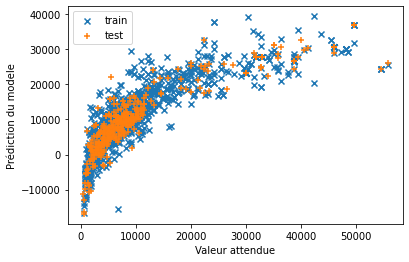

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

mlr = LinearRegression()  
mlr.fit(X_train, y_train)

print("Ordonnée à l'origine : ", mlr.intercept_)
print("Coefficients:")
print(list(zip(X_train, mlr.coef_)) ,'\n')


y_pred= mlr.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Model Score: ', mlr.score(X_test,y_test))

mlr_diff = pd.DataFrame({'Prix attendu': y_test, 'Prix prédit': y_pred, 'Taux de variation' : ((y_pred-y_test)/y_test)*100})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(mlr_diff.head())


y_train_pred = mlr.predict(X_train)

fig = plt.figure(1)
plt.scatter(y_train, y_train_pred, marker='x', label='train')
plt.scatter(y_test , y_pred , marker='+', label='test')

plt.legend()
plt.xlabel('Valeur attendue')
plt.ylabel('Prédiction du modele')

Modèle de forêt d'arbres décisitionnels, on remarque qu'il affiche un meilleur score, cela se voit clairement sur le graphe où les données sont affichées sous une forme linéaire car les prédictions sont justes.

## Modèle polynomial

Mean Absolute Error: 2066.215201023012
Mean Squared Error: 32213977.743871965
Root Mean Squared Error: 3301.859773432994
Le score R2 est 0.9178887847918944


Text(0, 0.5, 'Prédiction du modele')

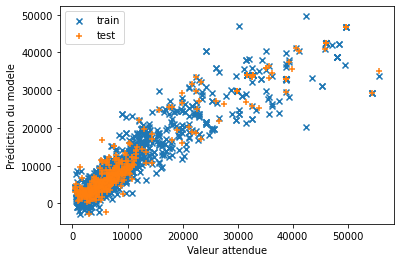

In [36]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures 
 
polynomial_features= PolynomialFeatures(degree=2)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.fit_transform(X_test)
model = LinearRegression()
model.fit(X_train_poly, y_train)

y_train_predict = model.predict(X_train_poly)
y_predict = model.predict(X_test_poly)

rmse = (np.sqrt(mean_squared_error(y_test, y_predict)))
r2 = r2_score(y_test, y_predict)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Le score R2 est {}'.format(r2))

model_diff = pd.DataFrame({'Prix attendu': y_test, 'Prix prédit': y_predict, 'Taux de variation' : ((y_predict-y_test)/y_test)*100})
model_

fig = plt.figure(1)
plt.scatter(y_train, y_train_predict, marker='x', label='train')
plt.scatter(y_test , y_predict , marker='+', label='test')
plt.legend()
plt.xlabel('Valeur attendue')
plt.ylabel('Prédiction du modele')